
# **PDE solvers for CFD: Womanium & Wiser 2025 Quantum Program Project**


This notebook contains all the codes related to the solving of the **Burgers' Equation for 1D Shock Tube**, given by:
$$\frac{\partial u}{\partial t} +\frac{u \partial u}{\partial x} = \frac{\nu\partial^2 u}{\partial x²}$$
Domain: $x$ $\in$ [0,1]
<br>IC: Riemann step $u(x,0)$ = 1 for $x$ $\leq$ 0.5, 0 otherwise
<br>BC (Dirichlet): $u(0,t)$ = $u_L$, $u(L,t)$ = $u_R$ for all $t$ $>$ 0 

This is done using:

-  a quantum solver: **Quantum Tensor-Network (QTN)** and,
-  a classical solving technique: **Euler Forward + Upwind convection + Central diffusion** for comparison

## Quantum solver: Quantum Tensor-Network (QTN)

D2 (Second Derivative) Matrix (8x8):
[[-130050.   65025.       0.       0.       0.]
 [  65025. -130050.   65025.       0.       0.]
 [      0.   65025. -130050.   65025.       0.]
 [      0.       0.   65025. -130050.   65025.]
 [      0.       0.       0.   65025. -130050.]]...

D1 (First Derivative) Matrix (8x8):
[[   0.   127.5    0.     0.     0. ]
 [-127.5    0.   127.5    0.     0. ]
 [   0.  -127.5    0.   127.5    0. ]
 [   0.     0.  -127.5    0.   127.5]
 [   0.     0.     0.  -127.5    0. ]]...



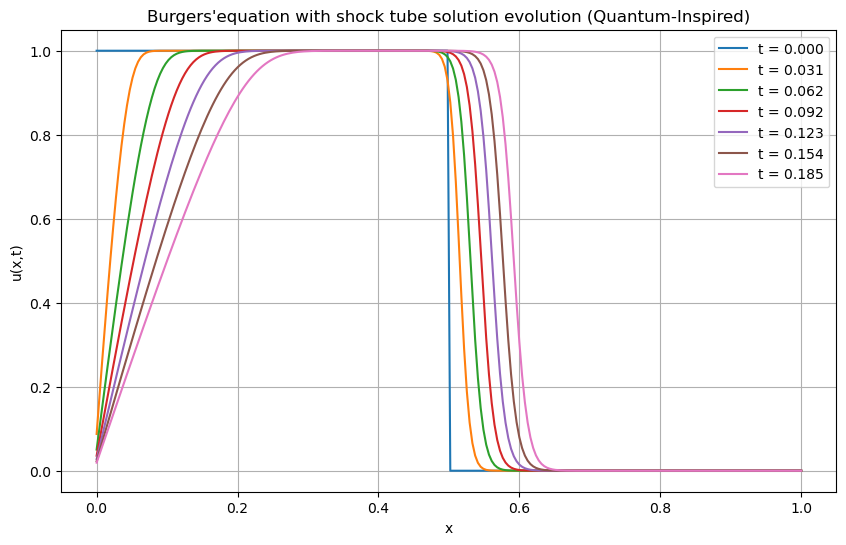

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import quimb.tensor as qtn
import scipy.sparse as sp


# Definition of parameters
N = 8                        # Number of qubits 
n = 2 ** N                  # Number of grid points
L = 1.0                    # Length
v = 0.005                 # viscosity
T = 0.2                    # final time 
n_steps = 260                # number of time steps
dt = T / n_steps             # time step


#Discretization of space domain
x = np.linspace(0, L, n)
dx = x[1] - x[0]               # space step


#Initialisation of u at time t=0
u = np.zeros(n)
u_L = 1       
u_R = 0     
for i in range(len(x)):
    if x[i] <= 0.5: 
        u[i]=u_L 
    else:
        u[i]=u_R 


#Integration of Boundary Condition (BC)
u[0]=1
u[-1]=0

#Initialisation of solutions
solution = [u.copy()]



#Convertion of u to MPS form
mps = qtn.MatrixProductState.from_dense(u, dims=2) 



#Generation of the matrix representations of the differential operators contained in the Burgers' equation 
def create_D2_matrix(N, dx):
    """
    Creates the sparse matrix for the second derivative (D_xx) using central
    finite differences.
    """
    main_diag = -2 * np.ones(N)
    off_diag = np.ones(N - 1)

    # Create a tridiagonal matrix
    D2 = sp.diags([off_diag, main_diag, off_diag], [-1, 0, 1], shape=(N, N), format='csc')
    D2 /= (dx**2)
    return D2

def create_D1_matrix(N, dx):
    """
    Creates the sparse matrix for the first derivative (D_x) using central
    finite differences.
    """
    
    off_diag_pos = np.ones(N - 1)
    off_diag_neg = -np.ones(N - 1)

    # Create a tridiagonal matrix
    D1 = sp.diags([off_diag_neg, off_diag_pos], [-1, 1], shape=(N, N), format='csc')
    D1 /= (2 * dx)
    return D1

# Generate the matrices
D2_matrix = create_D2_matrix(n, dx)
D1_matrix = create_D1_matrix(n, dx)

print(f"D2 (Second Derivative) Matrix ({N}x{N}):\n{D2_matrix.A[:5,:5]}...\n") # .A for converting to dense numpy array
print(f"D1 (First Derivative) Matrix ({N}x{N}):\n{D1_matrix.A[:5,:5]}...\n")


# Convertion of the Matrices to MPOs using quimb
num_sites = int(np.log2(n))
if 2**num_sites != n:
    raise ValueError(f"N must be a power of 2 for this MPO conversion example. Got n={n}")

physical_dims = (2,) * num_sites

# Convert D2 to MPO
D2_mpo = qtn.MatrixProductOperator.from_dense(D2_matrix.A, dims=2)

# Convert D1 to MPO
D1_mpo = qtn.MatrixProductOperator.from_dense(D1_matrix.A, dims=2)



#Now, let us perform time evolution for our mps
viscous_term_mps = v*D2_mpo @ mps
du_dx_mps = D1_mpo @ mps
for i in range (1,n_steps):
    u_vec = mps.to_dense()
    du_dx_vec = D1_mpo.to_dense() @ u_vec
    nonlinear_term_vec = -u_vec * du_dx_vec
    viscous_term_vec = v * (D2_mpo.to_dense() @ u_vec)      
    d_u_dt_vec = nonlinear_term_vec + viscous_term_vec
    d_u_dt_mps = qtn.MatrixProductState.from_dense(d_u_dt_vec, dims=2)
    mps = mps + dt * d_u_dt_mps
    u_new = mps.to_dense()
    solution.append(u_new.copy())


# Visualization of the solution
plt.figure(figsize=(10, 6))
for i, u in enumerate(solution[::40]):  # plotting every les 40 steps
    plt.plot(x, u, label=f't = {i*dt*40:.3f}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("Burgers'equation with shock tube solution evolution (Quantum-Inspired)")
plt.legend()
plt.grid()
plt.show()



## **Classical Solver: Explicit Upwind Scheme with Central Diffusion**

u(x,t)=
[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.76522956e-76
  4.43181669e-77 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.26648831e-74
  3.20173300e-75 0.00000000e+00]
 ...
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.72150865e-17
  7.76563281e-18 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.93056746e-17
  8.71324263e-18 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 2.16361605e-17
  9.77013118e-18 0.00000000e+00]]


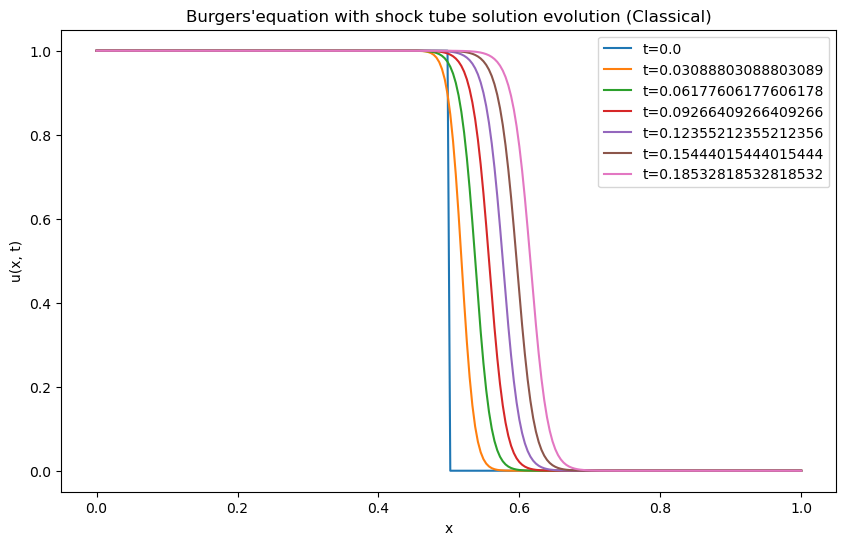

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Define some constant parameters
L=1        #length
v=0.005     #viscosity

#Discretize the space-time domain
x=np.linspace(0,L,256)
t=np.linspace(0,0.2,260)

#Generate the space-time grid
X,T=np.meshgrid(x,t)  


#Define space and time steps
dx= x[1]-x[0]
dt=t[1]-t[0]

#Integration of the Initial Condition (IC)
u=np.zeros_like(X)
for i in range(len(x)):
    if x[i] <= 0.5: 
        u[0,i]=1
    else:
        u[0,i]=0


#Integration of Boundary Condition (BC)
u[:,0]=1
u[:,-1]=0


#Numerical evaluation of the solution of the PDE, using Finite Difference Method (FDM) for discretization
for i in range (len(t)-1):
    for j in range (1,len(x)-1):
        u[i+1,j] = u[i,j] - u[i,j]*(u[i,j]-u[i,j-1])*dt/dx + v*(u[i,j+1]-2*u[i,j]+u[i+1,j-1])*dt/(dx**2)
    

#Print the numerical solution
print("u(x,t)=")
print(u)
#print("x=",x)
#print("t=",t) 
#print("X=",X)
#print("T=",T)

#Visualization of the solution
plt.figure(figsize=(10, 6))
for i in range (len(t)):
    if i%40==0:
        plt.plot(x, u[i,:], label=f't={t[i]}')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title("Burgers'equation with shock tube solution evolution (Classical)")
plt.legend()
plt.show()